# **COMP 551 Mini-project 1**

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from io import StringIO
import urllib.request
from scipy import stats

np.random.seed(42)

##Implement Models

###KNN

In [ ]:
# distance function
euclidean = lambda x1, x2: np.sqrt(np.sum((x1-x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
cosine = lambda x1, x2: (1 - np.dot(x1/(np.linalg.norm(x1, axis=1).reshape(-1,1)),(x2/(np.linalg.norm(x2,axis=1).reshape(-1,1))).T)).T

class KNN:

    def __init__(self, K=1, dist_fn=euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return

    def fit(self, x, y):
        self.x = x
        self.y = y
        self.C = np.max(y)+1
        return self

    def predict(self, x_test):
        num_test = x_test.shape[0]
        if self.dist_fn == cosine:
            distances = self.dist_fn(self.x, x_test)
        else:
            distances = self.dist_fn(self.x[None, :, :], x_test[:, None, :])
        knns = np.zeros((num_test, self.K), dtype=int) # store the K nearest neighbors for each instance
        y_prob = np.zeros((num_test, self.C)) # store the probability for each category for each instance
        for i in range(num_test):
            knns[i, :] = np.argsort(distances[i])[:self.K]
            y_prob[i, :] = np.bincount(self.y[knns[i, :]], minlength=self.C)
        y_prob /= self.K
        return y_prob, knns

###Decision Tree

In [ ]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices
        self.left = None
        self.right = None
        self.split_feature = None
        self.split_value = None
        if parent:
            self.depth = parent.depth + 1
            self.num_classes = parent.num_classes
            self.data = parent.data
            self.labels = parent.labels
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes)
            self.class_prob = class_prob / np.sum(class_prob)

In [ ]:
def greedy_test(node, cost_fn):
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

In [ ]:
# cost functions

def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)

def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]
    return -np.sum(class_probs * np.log(class_probs))

def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))

In [ ]:
# stopping criteria function

def stopping_criteria_met(tree,node,criteria='max_depth'):
    if criteria == "min_leaves":
        return (len(node.data_indices) <= tree.min_leaf_instances)
    elif criteria == "small_cost":
        return (tree.cost_fn(node.labels) <= tree.cost_threshold)
    else: # default criteria is max depth 
        return (node.depth == tree.max_depth)


In [ ]:
class DecisionTree:

    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1, cost_threshold = 0.05):
        self.max_depth = max_depth
        self.root = None
        self.cost_fn = cost_fn
        self.num_classes = num_classes
        self.min_leaf_instances = min_leaf_instances
        self.cost_threshold = cost_threshold

    def fit(self, data, labels):
        pass

    def predict(self, data_test):
        pass

def fit(self, data, labels,c1='max_depth',c2='max_depth',c3='max_depth'):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    self._fit_tree(self.root,c1,c2,c3)
    return self

def _fit_tree(self, node,c1,c2,c3):

    if stopping_criteria_met(self,node,c1) or stopping_criteria_met(self,node,c2) or stopping_criteria_met(self,node,c3):
        return

    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    if np.isinf(cost):
        return

    test = node.data[node.data_indices,split_feature] <= split_value
    node.split_feature = split_feature
    node.split_value = split_value
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    self._fit_tree(left,c1,c2,c3)
    self._fit_tree(right,c1,c2,c3)
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

###Evaluate Accuracy

In [ ]:
def evaluate_acc(y_predict, y_true):
  acc = np.sum(y_predict == y_true)/y_true.shape[0]
  return acc

## Hepatitis Dataset


*   We would like to predict if a patient lives or dies based on some features


###Load and Clean Dataset

##### **Load the Dataset**

In [ ]:
headers = ['CLASS', 'age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm',
           'spleen_palpable', 'spiders', 'ascites', 'varices', 'bilirubin', 'alk_phosphate', 'sgot', 'albumin', 'protime', 'histology']

# read dataset from file
hepatitis_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data', delimiter=",", names=headers, index_col=False)

# display the first 5 instances and shape of dataset
print(hepatitis_df.head())
print(hepatitis_df.shape)

   CLASS  age  sex steroid  ...  sgot albumin protime histology
0      2   30    2       1  ...    18     4.0       ?         1
1      2   50    1       1  ...    42     3.5       ?         1
2      2   78    1       2  ...    32     4.0       ?         1
3      2   31    1       ?  ...    52     4.0      80         1
4      2   34    1       2  ...   200     4.0       ?         1

[5 rows x 20 columns]
(155, 20)


##### **Data Cleaning**

In [ ]:
# remove instances with missing values
hepatitis_df = hepatitis_df[hepatitis_df.eq('?').any(1) == False]
print(hepatitis_df.head())
print(hepatitis_df.shape)

    CLASS  age  sex steroid  ...  sgot albumin protime histology
5       2   34    1       2  ...    28     4.0      75         1
10      2   39    1       1  ...    30     4.4      85         1
11      2   32    1       2  ...   249     3.7      54         1
12      2   41    1       2  ...    60     3.9      52         1
13      2   30    1       2  ...   144     4.9      78         1

[5 rows x 20 columns]
(80, 20)


In [ ]:
# convert features that are objects into integers and floats
for h in headers:
  try:
    hepatitis_df[h] = hepatitis_df[h].astype(int)
  except (ValueError) as e:
    hepatitis_df[h] = hepatitis_df[h].astype(float)

print(hepatitis_df.dtypes)

CLASS                int64
age                  int64
sex                  int64
steroid              int64
antivirals           int64
fatigue              int64
malaise              int64
anorexia             int64
liver_big            int64
liver_firm           int64
spleen_palpable      int64
spiders              int64
ascites              int64
varices              int64
bilirubin          float64
alk_phosphate        int64
sgot                 int64
albumin            float64
protime              int64
histology            int64
dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


*alternative cleaning method (not used)*
```
# change data type to int and float
hepatitis_df.replace({'?': 0},inplace =True)
hepatitis_df[['steroid', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices',
       'alk_phosphate', 'sgot', 'protime']] = hepatitis_df[['steroid', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm',
       'spleen_palpable', 'spiders', 'ascites', 'varices', 'alk_phosphate', 'sgot', 'protime']].astype(int)
hepatitis_df[['bilirubin', 'albumin']] = hepatitis_df[['bilirubin', 'albumin']].astype(float)

# compute the number of missing data for each feature
hepatitis_df.replace({0: None}, inplace=True)
print(hepatitis_df.isnull().sum())

# we can see that protime has a lot of missing data so we remove it
del hepatitis_df['protime']

# for the other missing data, if it's categorical then replace with mode, if numerical then replace with mean
cat = ['steroid', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices']
num = ['bilirubin', 'alk_phosphate', 'sgot', 'albumin']

hepatitis_df[cat] = hepatitis_df[cat].fillna(hepatitis_df[cat].median()) # why doesn't mode work??? I don't understand??? #LOL
hepatitis_df[num] = hepatitis_df[num].fillna(hepatitis_df[num].mean())
print(hepatitis_df)

# type conversion again...
hepatitis_df[['CLASS', 'age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm',
           'spleen_palpable', 'spiders', 'ascites', 'varices', 'alk_phosphate', 'sgot', 'histology']] = hepatitis_df[['CLASS', 'age', 'sex', 
           'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 
           'varices', 'alk_phosphate', 'sgot', 'histology']].astype(int)
hepatitis_df[['bilirubin', 'albumin']] = hepatitis_df[['bilirubin', 'albumin']].astype(float)
```



##### **Data Normalization**

In [ ]:
# For categorical features, minus all values by 1 so that each value takes on class 0 or 1
# For continuous features, we perform z-score normalization
hepatitis_df.reset_index(drop=True, inplace=True)

classdata = hepatitis_df['CLASS']
categorical_features = ['sex','steroid', 'antivirals','fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices','histology']
continuous_features = ['age','bilirubin','alk_phosphate','sgot','albumin','protime']

hepatitis_df[categorical_features] = hepatitis_df[categorical_features] - 1
hepatitis_np = hepatitis_df[continuous_features].to_numpy()
z_normalized = (hepatitis_np - np.mean(hepatitis_np))/np.sqrt(np.var(hepatitis_np))
z_normalized = pd.DataFrame(z_normalized,columns=continuous_features)

hepatitis_df = pd.concat([classdata,hepatitis_df[categorical_features],z_normalized],axis=1)
hepatitis_df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,CLASS,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
0,2,0,1,1,1,1,1,1,1,1,1,1,1,0,-0.278015,-0.897161,0.863008,-0.390247,-0.839174,0.488902
1,2,0,0,0,1,1,1,0,0,1,1,1,1,0,-0.184489,-0.889679,0.545018,-0.352837,-0.831692,0.675955
2,2,0,1,0,0,1,1,1,0,1,0,1,1,0,-0.315426,-0.895290,0.189617,3.743624,-0.844786,0.096091
3,2,0,1,0,0,1,1,1,0,1,1,1,1,0,-0.147078,-0.897161,0.601134,0.208322,-0.841045,0.058680
4,2,0,1,1,0,1,1,1,0,1,1,1,1,0,-0.352837,-0.872844,0.152207,1.779568,-0.822340,0.545018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2,0,1,0,1,1,1,1,1,1,1,1,1,1,-0.072257,-0.889679,0.675955,-0.090962,-0.835433,0.675955
76,1,0,0,1,0,0,1,1,1,0,0,1,1,1,0.002564,-0.887808,0.675955,0.395376,-0.848527,-0.259310
77,2,0,0,1,0,1,1,1,1,1,1,1,1,1,-0.334131,-0.891549,0.488902,2.322022,-0.835433,0.096091
78,2,1,0,1,0,1,1,1,1,0,0,1,0,1,0.077385,-0.885938,0.601134,-0.558595,-0.837304,-0.016141


##### **Basic Descriptive Statistics**

           CLASS        sex    steroid  ...       sgot    albumin    protime
count  80.000000  80.000000  80.000000  ...  80.000000  80.000000  80.000000
mean    1.837500   0.137500   0.525000  ...   0.620307  -0.842097   0.255320
std     0.371236   0.346547   0.502525  ...   1.339299   0.010780   0.438224
min     1.000000   0.000000   0.000000  ...  -0.652121  -0.874714  -0.913996
25%     2.000000   0.000000   0.000000  ...  -0.338808  -0.848527  -0.053552
50%     2.000000   0.000000   1.000000  ...   0.142854  -0.839174   0.245733
75%     2.000000   0.000000   1.000000  ...   1.007974  -0.835433   0.530989
max     2.000000   1.000000   1.000000  ...   6.942231  -0.820469   0.956535

[8 rows x 20 columns]


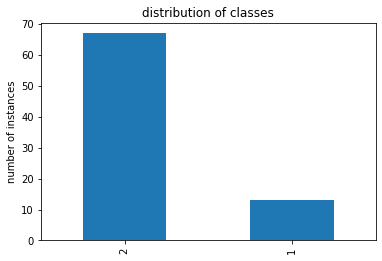

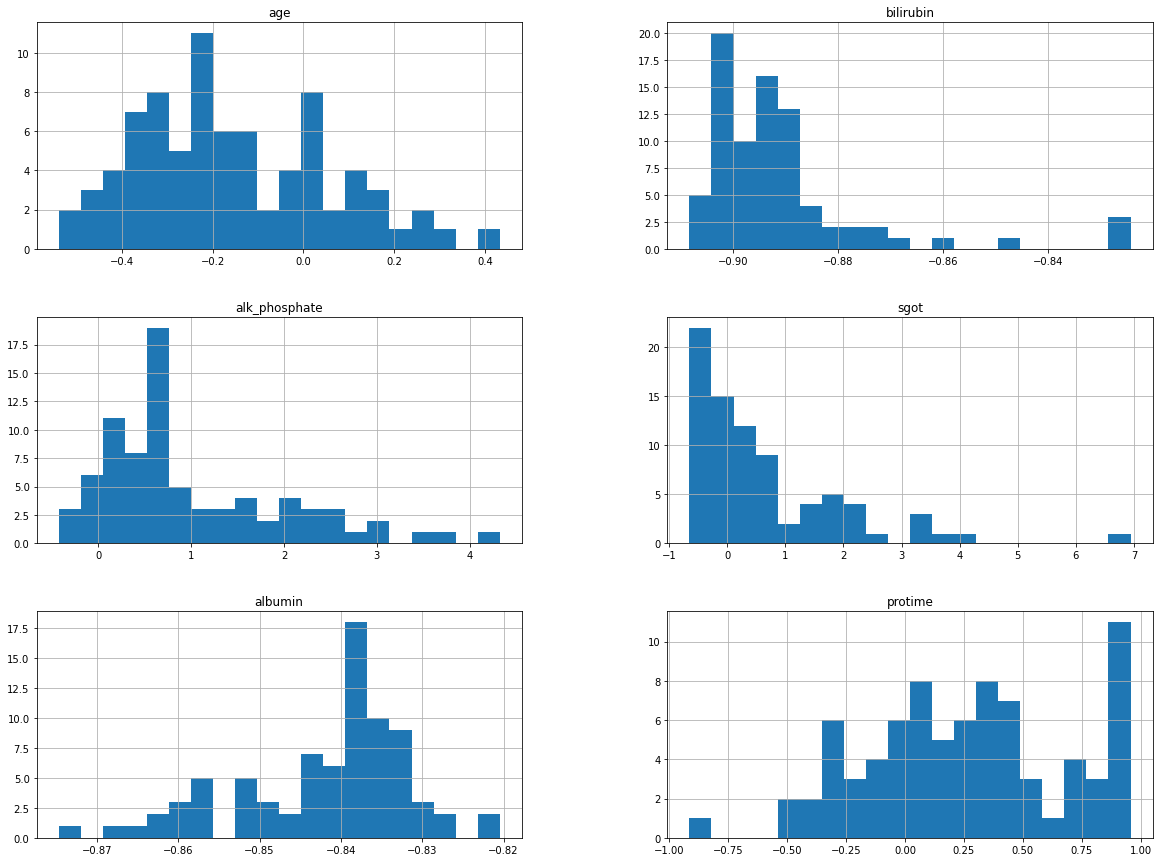

In [ ]:
# basic descriptive statistics
print(hepatitis_df.describe())
# plot the distribution of the classes using bar plots
hepatitis_df['CLASS'].value_counts().plot(ylabel='number of instances', kind='bar', title='distribution of classes')
plt.show()
# plot the distribution of numerical features using histograms
hepatitis_df.hist(column=["age", 'bilirubin', 'alk_phosphate', 'sgot', 'albumin', 'protime'], bins=20, figsize=(20,15))
plt.show()

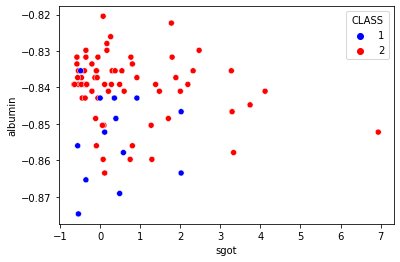

In [ ]:
sns.scatterplot(x=hepatitis_df['sgot'],y=hepatitis_df['albumin'],hue=hepatitis_df['CLASS'], palette=['blue','red'],data=hepatitis_df)

###Run Experiments

##### **Feature Selection**

In [ ]:
cat = ['sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices', 'histology']
num = ['age','bilirubin','alk_phosphate','sgot','albumin','protime']

# compute chi square between a categorical feature and the class
selected_features = []

for i in range(len(cat)):
  # contigency table
  ct = pd.crosstab(index=hepatitis_df[cat[i]], columns=hepatitis_df['CLASS'])
  (chi2, p, _, _) = stats.chi2_contingency([ct.iloc[0].values, ct.iloc[1].values])
  # select the features with p < 0.05
  if (p < 0.05):
    selected_features.append(cat[i])

'''
# compute t-test for numerical features
# compare the mean of instances classified as class 1 with those classified as class 2
for i in range(len(num)):
  class1 = hepatitis_df.loc[hepatitis_df['CLASS']==1, num[i]]
  class2 = hepatitis_df.loc[hepatitis_df['CLASS']==2, num[i]]
  [t, p] = stats.ttest_ind(class1, class2)
  if (p < 0.05):
    selected_features.append(num[i])
'''

# update dataframe with selected features
hepatitis_df = hepatitis_df[['CLASS'] + selected_features + num]
hepatitis_df

,CLASS,malaise,spiders,ascites,varices,histology,age,bilirubin,alk_phosphate,sgot,albumin,protime
0,2,1,1,1,1,0,-0.278015,-0.897161,0.863008,-0.390247,-0.839174,0.488902
1,2,1,1,1,1,0,-0.184489,-0.889679,0.545018,-0.352837,-0.831692,0.675955
2,2,1,0,1,1,0,-0.315426,-0.895290,0.189617,3.743624,-0.844786,0.096091
3,2,1,1,1,1,0,-0.147078,-0.897161,0.601134,0.208322,-0.841045,0.058680
4,2,1,1,1,1,0,-0.352837,-0.872844,0.152207,1.779568,-0.822340,0.545018
...,...,...,...,...,...,...,...,...,...,...,...,...
75,2,1,1,1,1,1,-0.072257,-0.889679,0.675955,-0.090962,-0.835433,0.675955
76,1,0,0,1,1,1,0.002564,-0.887808,0.675955,0.395376,-0.848527,-0.259310
77,2,1,1,1,1,1,-0.334131,-0.891549,0.488902,2.322022,-0.835433,0.096091
78,2,1,0,1,0,1,0.077385,-0.885938,0.601134,-0.558595,-0.837304,-0.016141


##### **Split the Data**

In [ ]:
# convert pandas dataframe to numpy array
hepatitis_array = hepatitis_df.to_numpy()

x, y = hepatitis_array[:, 1:], hepatitis_array[:, 0]
y = y.astype(int)-1
(N, D), C = x.shape, np.max(y)+1

# split the dataset into train and test
inds = np.random.permutation(N)
x_train, y_train = x[inds[:round(N*0.7)]], y[inds[:round(N*0.7)]]
x_test, y_test = x[inds[round(N*0.7):]], y[inds[round(N*0.7):]]

##### **Hyperparameter Tuning for KNN**

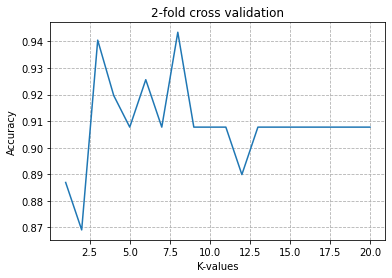

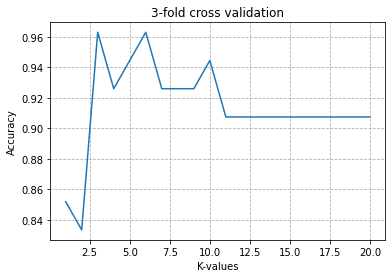

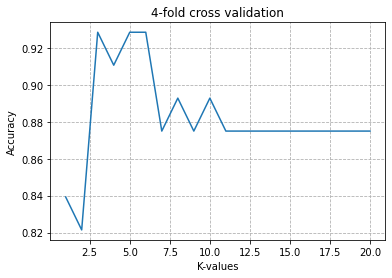

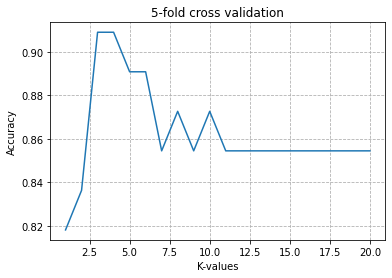

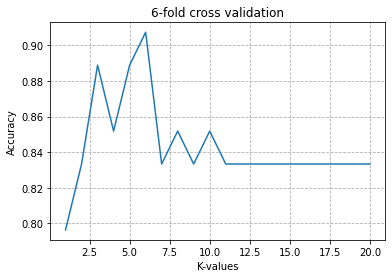

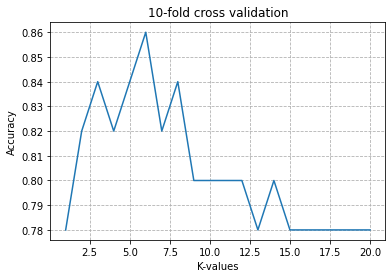

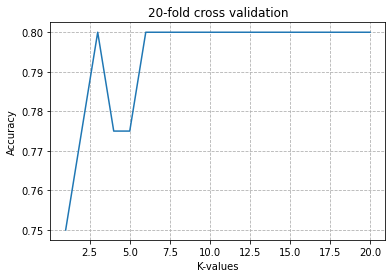

20
the best fold number is  3
the best k value is  3
and the corresponding accuracy rate is  0.9629629629629629


In [ ]:
foldNums = [2,3,4,5,6,10,20]
K = 20
averageAccArrAcross = np.zeros((len(foldNums),K))
index=0
for foldNum in foldNums:
  interval = int(x_train.shape[0] / foldNum)
  for k in range(1,K+1):
    averageAcc = 0
    for fold in range(1,foldNum+1):
      model = KNN(K=k, dist_fn=cosine)

      #splits train & validation set
      xTrainSet = np.append(x[inds[0:interval*fold]], x[inds[interval*(fold+1):]], axis=0)
      yTrainSet = np.append(y[inds[0:interval*fold]], y[inds[interval*(fold+1):]], axis=0)
      xValiSet = x[inds[(interval*fold):(interval*(fold+1))]]
      yValiSet = y[inds[(interval*fold):(interval*(fold+1))]]
      yProb, knns = model.fit(xTrainSet, yTrainSet).predict(xValiSet)
      #print('knns shape:', knns.shape)
      #print('y_prob shape:', yProb.shape)

      #To get hard predictions by choosing the class with the maximum probability
      yPred = np.argmax(yProb,axis=-1)
      accuracy = evaluate_acc(yPred,yValiSet)
      averageAcc = averageAcc + accuracy

      #boolean array to later slice the indexes of correct and incorrect predictions
      correct = yValiSet == yPred
      incorrect = np.logical_not(correct)

    averageAcc = averageAcc / foldNum
    averageAccArrAcross[index][k-1] = averageAcc

  index = index+1 #index of fold
for i in np.arange(7): #iteratre through foldNums
  plt.plot(range(1,K+1), averageAccArrAcross[i])
  plt.title(str(foldNums[i])+"-fold cross validation")
  plt.grid(True, which="both", linestyle='--')
  plt.xlabel("K-values")
  plt.ylabel("Accuracy")
  plt.show()

print(averageAccArrAcross.shape[1])
maxRow = int((np.argmax(averageAccArrAcross)+1) / averageAccArrAcross.shape[1])
maxColumn = ((np.argmax(averageAccArrAcross)+1) % averageAccArrAcross.shape[1])-1


if (maxRow > averageAccArrAcross.shape[0]-1):
  maxRow = averageAccArrAcross.shape[0]-1
if (maxColumn > averageAccArrAcross.shape[1]-1):
  maxColumn = averageAccArrAcross.shape[1]-1

bestK = maxColumn+1
bestFold = foldNums[maxRow]


print("the best fold number is ",bestFold)
print("the best k value is ", bestK)
print("and the corresponding accuracy rate is ",averageAccArrAcross[maxRow][maxColumn])

##### **Hyperparameter Tuning for Decision Tree**

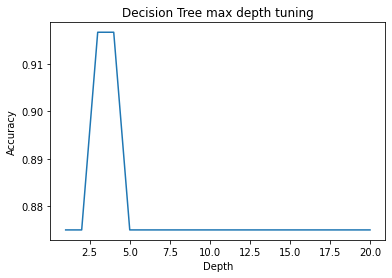

the best max depth value is  3
and the corresponding accuracy rate is  0.9166666666666666


In [ ]:
# decision tree
DT_acc = np.zeros(20)
for d in range(1,21):
  tree = DecisionTree(max_depth=d,cost_fn=cost_gini_index)
  probs_test = tree.fit(x_train, y_train).predict(x_test)
  y_pred_DT = np.argmax(probs_test, 1)
  DT_acc[d-1] = evaluate_acc(y_pred_DT, y_test)
plt.plot(np.arange(1,21), DT_acc)
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree max depth tuning")
plt.show()

bestD = np.argmax(DT_acc)+1

print("the best max depth value is ", bestD)
print("and the corresponding accuracy rate is ",DT_acc[bestD-1])

##### **Running Actual KNN model**

In [ ]:
# K nearest neighbours
model = KNN(K=bestK,dist_fn=cosine)
y_prob, knns = model.fit(x_train, y_train).predict(x_test)
y_pred_KNN = np.argmax(y_prob, axis=-1)
test_accuracy = evaluate_acc(y_pred_KNN, y_test)
print("the KNN test set accuracy for the hepatitis dataset is ",test_accuracy)

the KNN test set accuracy for the hepatitis dataset is  0.9166666666666666


##### **Decision Boundary for KNN**

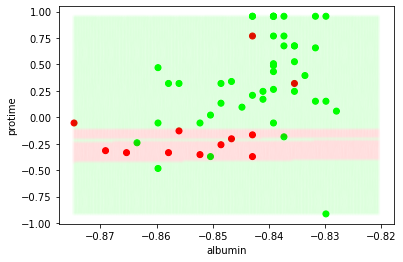

In [ ]:
# plotting albumin and protime

x_plot = np.stack((x[:,-2], x[:,-1]), axis=1)
x_train_plot = np.stack((x_train[:,-2], x_train[:,-1]), axis=1)

x0v = np.linspace(np.min(x_plot[:,0]), np.max(x_plot[:,0]), 200)
x1v = np.linspace(np.min(x_plot[:,1]), np.max(x_plot[:,1]), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = KNN(K=bestK,dist_fn=cosine)

y_train_prob = np.zeros((y_train.shape[0], 3))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

#to get class probability of all the points in the 2D grid
y_prob_all, _ = model.fit(x_train_plot, y_train).predict(x_all)

y_pred_all = np.zeros((y_prob_all.shape[0],3))
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

plt.scatter(x_train_plot[:,0], x_train_plot[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
plt.xlabel('albumin')
plt.ylabel('protime')
plt.show()
#sns.scatterplot(x=hepatitis_df['albumin'],y=hepatitis_df['protime'],hue=hepatitis_df['CLASS'], palette=['blue','red'],data=hepatitis_df)

##### **Running Actual Decision tree model**

In [ ]:
# decision tree
bestDepth = 20 #change after hyperparamter is tuned!
tree = DecisionTree(max_depth=bestDepth,cost_fn=cost_gini_index)
probs_test = tree.fit(x_train, y_train).predict(x_test)
y_pred_DT = np.argmax(probs_test, 1)
test_accuracy = evaluate_acc(y_pred_DT, y_test)
print("the Decision Tree test set accuracy for the diabetes dataset is ",test_accuracy)

the Decision Tree test set accuracy for the diabetes dataset is  0.875


##### **Decision Boundary for Decision Tree**

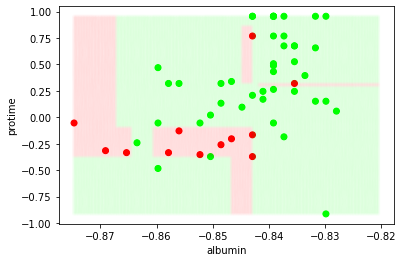

In [ ]:
x_plot = np.stack((x[:,-2], x[:,-1]), axis=1)
x_train_plot = np.stack((x_train[:,-2], x_train[:,-1]), axis=1)

x0v = np.linspace(np.min(x_plot[:,0]), np.max(x_plot[:,0]), 200)
x1v = np.linspace(np.min(x_plot[:,1]), np.max(x_plot[:,1]), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = DecisionTree(max_depth=bestDepth,cost_fn=cost_gini_index)

y_train_prob = np.zeros((y_train.shape[0], 3))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

#to get class probability of all the points in the 2D grid
y_prob_all = model.fit(x_train_plot, y_train).predict(x_all)

y_pred_all = np.zeros((y_prob_all.shape[0],3))
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

plt.scatter(x_train_plot[:,0], x_train_plot[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
plt.xlabel('albumin')
plt.ylabel('protime')
plt.show()

---
##Diabetic Retinopathy Debrecen Dataset




### Load and Clean Dataset

##### **Load the Dataset**

In [ ]:
request_url = urllib.request.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff")
data = arff.loadarff(StringIO(request_url.read().decode()))
#print(data)
df = pd.DataFrame(data[0])
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,Class
0,1.0,1.0,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1.0,b'0'
1,1.0,1.0,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0.0,b'0'
2,1.0,1.0,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0.0,b'1'
3,1.0,1.0,55.0,53.0,53.0,50.0,43.0,31.0,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0.0,b'0'
4,1.0,1.0,44.0,44.0,44.0,41.0,39.0,27.0,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0.0,b'1'


##### **Data Cleaning**

In [ ]:
# change class to binary int
df['Class'] = df['Class'].astype(str)
df.replace(to_replace={"b\'0\'":'0', "b\'1\'":'1'}, value=None, inplace=True)
df['Class'] = df['Class'].astype(int)

# remove instances with missing values
hepatitis_df = hepatitis_df[hepatitis_df.eq('?').any(1) == False]
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,Class
0,1.0,1.0,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1.0,0
1,1.0,1.0,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0.0,0
2,1.0,1.0,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0.0,1
3,1.0,1.0,55.0,53.0,53.0,50.0,43.0,31.0,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0.0,0
4,1.0,1.0,44.0,44.0,44.0,41.0,39.0,27.0,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,1.0,1.0,34.0,34.0,34.0,33.0,31.0,24.0,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0.0,0
1147,1.0,1.0,49.0,49.0,49.0,49.0,45.0,37.0,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0.0,0
1148,1.0,0.0,49.0,48.0,48.0,45.0,43.0,33.0,30.461898,13.966980,1.763305,0.137858,0.011221,0.000000,0.000000,0.000000,0.560632,0.129843,0.0,0
1149,1.0,1.0,39.0,36.0,29.0,23.0,13.0,7.0,40.525739,12.604947,4.740919,1.077570,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1.0,1


##### **Data Normalization**

In [ ]:
# For continuous features, we performed z-score normalization
classdata = df['Class']
categorical_features = ['0','1','18']
continuous_features = []
for i in range(2,18):
  continuous_features.append(str(i))

# df[categorical_features] = df[categorical_features] - 1
to_np = df[continuous_features].to_numpy()
z_normalized = (to_np - np.mean(to_np))/np.sqrt(np.var(to_np))
z_normalized = pd.DataFrame(z_normalized,columns=continuous_features)

df = pd.concat([classdata,df[categorical_features],z_normalized],axis=1)
df

,Class,0,1,18,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,1.0,1.0,1.0,0.133603,0.133603,0.133603,0.026849,-0.008735,-0.151073,1.126257,-0.016706,-0.461692,-0.621792,-0.648592,-0.649011,-0.649115,-0.649115,-0.631929,-0.645695
1,0,1.0,1.0,0.0,0.204772,0.204772,0.133603,-0.008735,-0.079904,-0.186657,1.404321,0.197655,-0.530921,-0.640921,-0.649116,-0.649116,-0.649116,-0.649116,-0.630719,-0.644116
2,1,1.0,1.0,0.0,1.556980,1.485811,1.450227,1.272305,1.023214,0.525032,1.337475,0.346893,-0.197778,-0.476589,-0.599654,-0.635973,-0.647767,-0.648979,-0.630363,-0.644680
3,0,1.0,1.0,0.0,1.307889,1.236720,1.236720,1.129967,0.880876,0.453863,0.790749,0.007134,-0.324764,-0.539675,-0.619355,-0.639560,-0.648982,-0.649200,-0.632057,-0.645170
4,1,1.0,1.0,0.0,0.916460,0.916460,0.916460,0.809707,0.738538,0.311525,-0.007801,-0.344271,-0.634652,-0.649255,-0.649255,-0.649255,-0.649255,-0.649255,-0.632319,-0.644858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,0,1.0,1.0,0.0,0.560616,0.560616,0.560616,0.525032,0.453863,0.204772,-0.433194,-0.615895,-0.648147,-0.649144,-0.649255,-0.649255,-0.649255,-0.649255,-0.630129,-0.645099
1147,0,1.0,1.0,0.0,1.094382,1.094382,1.094382,1.094382,0.952045,0.667369,1.599580,0.324964,-0.362171,-0.614398,-0.649200,-0.649255,-0.649255,-0.649255,-0.630867,-0.644836
1148,0,1.0,0.0,0.0,1.094382,1.058798,1.058798,0.952045,0.880876,0.525032,0.434715,-0.152248,-0.586509,-0.644349,-0.648856,-0.649255,-0.649255,-0.649255,-0.629305,-0.644634
1149,1,1.0,1.0,1.0,0.738538,0.631785,0.382694,0.169187,-0.186657,-0.400164,0.792831,-0.200715,-0.480552,-0.610910,-0.629202,-0.637624,-0.640730,-0.643042,-0.631962,-0.645458


##### **Basic Descriptive Statistics**

             Class            0  ...           16           17
count  1151.000000  1151.000000  ...  1151.000000  1151.000000
mean      0.530843     0.996525  ...    -0.630637    -0.645396
std       0.499265     0.058874  ...     0.000998     0.000639
min       0.000000     0.000000  ...    -0.636168    -0.647194
25%       0.000000     1.000000  ...    -0.631361    -0.645846
50%       1.000000     1.000000  ...    -0.630633    -0.645461
75%       1.000000     1.000000  ...    -0.629909    -0.644999
max       1.000000     1.000000  ...    -0.628181    -0.641455

[8 rows x 20 columns]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf93ef6590>,
      dtype=object)

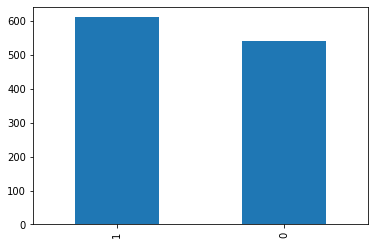

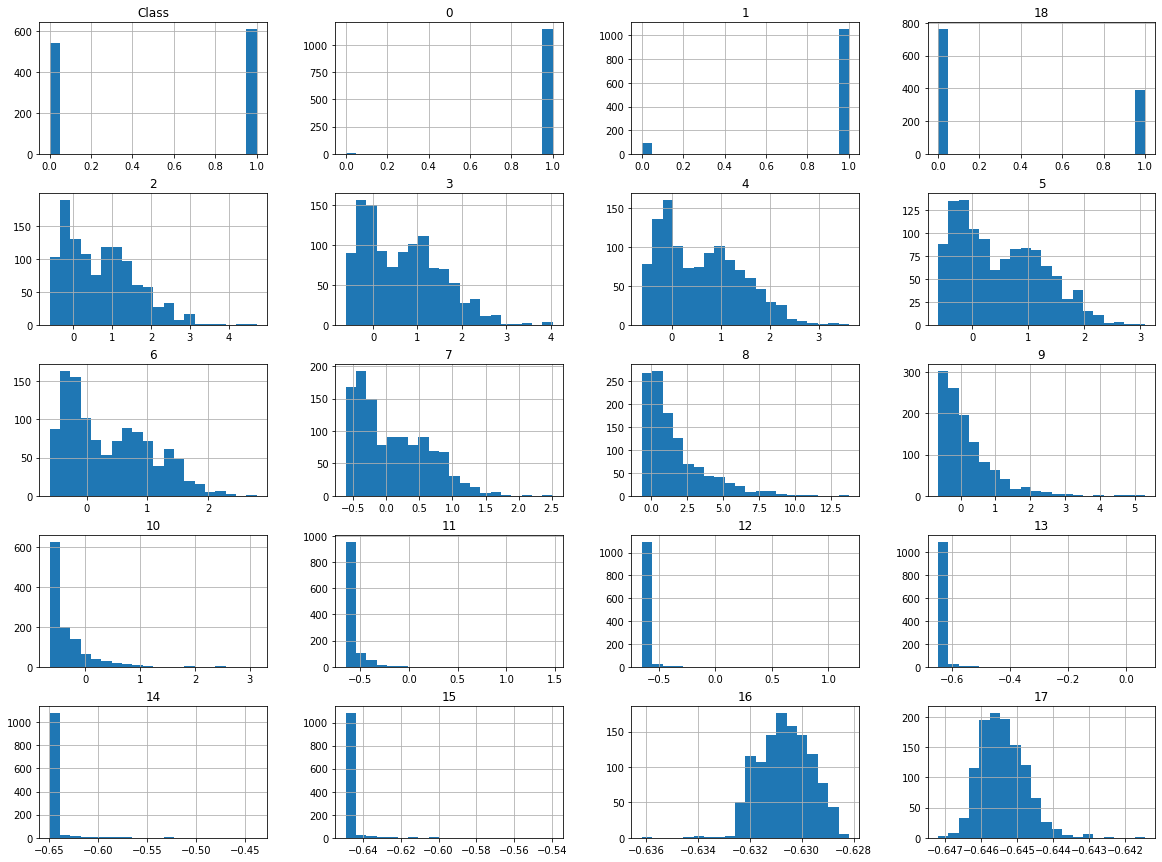

In [ ]:
print(df.describe())
df['Class'].value_counts().plot(kind='bar')
# plot the distribution of numerical features using histograms
df.hist(bins=20, figsize=(20,15))

### Run Experiments

##### **Feature Selection (not used)**

*chi square feature selection*

```
# compute chi square between two categorical variables
cat = ['0', '1', '18']

selected_cat_features = []
chi2_list = []
p_list = []

for i in range(len(cat)):
  # contigency table
  ct = pd.crosstab(index=df[cat[i]], columns=df['Class'])
  (chi2, p, _, _) = stats.chi2_contingency([ct.iloc[0].values, ct.iloc[1].values])
  if (p < 0.05):
    selected_cat_features.append(cat[i])
    chi2_list.append(chi2)
    p_list.append(p)

data = {'feature':selected_cat_features, 'chi2':chi2_list, 'p':p_list}
chi2_df = pd.DataFrame(data)
print(chi2_df)
```



*drop highly correlated features*


```
# compute correlation between features
df_corr = df.corr()
sns.heatmap(df_corr)

# drop highly correlated features
threshold = 0.8
columns = np.full((df_corr.shape[0],), True, dtype=bool)
for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = df.columns[columns]
df = df[selected_columns]
df_corr.head()
```



##### **Split the Data**

In [ ]:
# convert pandas dataframe to numpy array
diabetes_array = df.to_numpy()

x, y = diabetes_array[:, 1:], diabetes_array[:, 0]
y = y.astype(int)
(N, D), C = x.shape, np.max(y)+1

# split the dataset into train and test
np.random.seed(42)
inds = np.random.permutation(N)
x_train, y_train = x[inds[:round(N*0.7)]], y[inds[:round(N*0.7)]]
x_test, y_test = x[inds[round(N*0.7):]], y[inds[round(N*0.7):]]

##### **Hyperparamter Tuning for KNN**

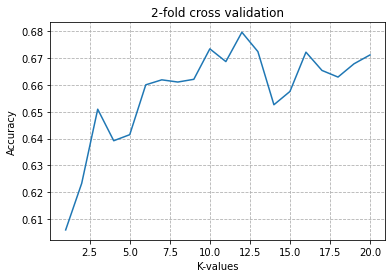

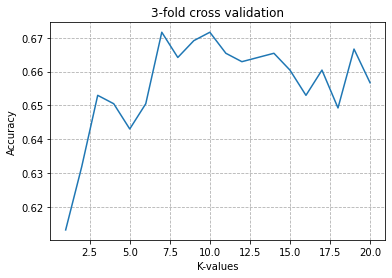

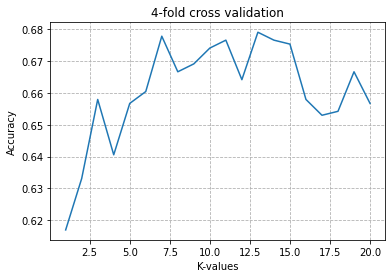

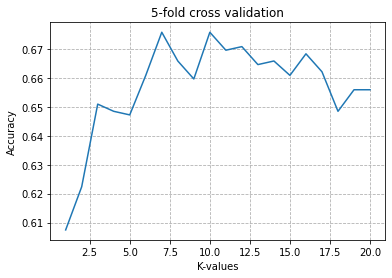

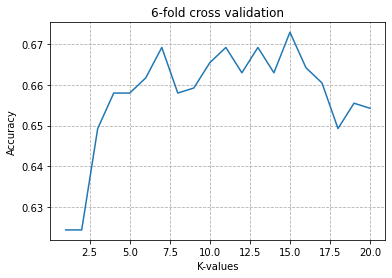

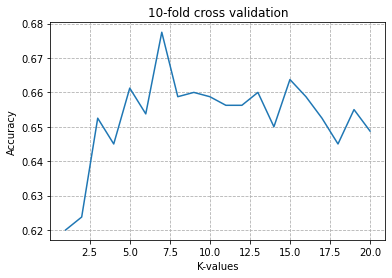

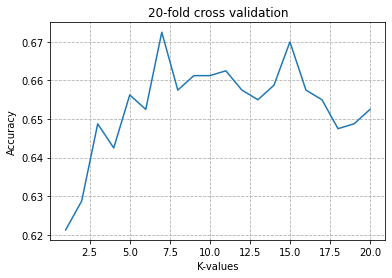

20
12
the best fold number is  2
the best k value is  12
and the corresponding accuracy rate is  0.6797173373610961


In [ ]:
foldNums = [2,3,4,5,6,10,20]
K = 20
averageAccArrAcross = np.zeros((len(foldNums),K))
index=0
for foldNum in foldNums:
  interval = int(x_train.shape[0] / foldNum)
  for k in range(1,K+1):
    averageAcc = 0
    for fold in range(1,foldNum+1):
      model = KNN(K=k, dist_fn=cosine)

      #splits train & validation set
      xTrainSet = np.append(x[inds[0:interval*fold]], x[inds[interval*(fold+1):]], axis=0)
      yTrainSet = np.append(y[inds[0:interval*fold]], y[inds[interval*(fold+1):]], axis=0)
      xValiSet = x[inds[(interval*fold):(interval*(fold+1))]]
      yValiSet = y[inds[(interval*fold):(interval*(fold+1))]]
      yProb, knns = model.fit(xTrainSet, yTrainSet).predict(xValiSet)
      #print('knns shape:', knns.shape)
      #print('y_prob shape:', yProb.shape)

      #To get hard predictions by choosing the class with the maximum probability
      yPred = np.argmax(yProb,axis=-1)
      accuracy = evaluate_acc(yPred,yValiSet)
      averageAcc = averageAcc + accuracy

      #boolean array to later slice the indexes of correct and incorrect predictions
      correct = yValiSet == yPred
      incorrect = np.logical_not(correct)

    averageAcc = averageAcc / foldNum
    averageAccArrAcross[index][k-1] = averageAcc

  index = index+1 #index of fold
for i in np.arange(7): #iteratre through foldNums
  plt.plot(range(1,K+1), averageAccArrAcross[i])
  plt.title(str(foldNums[i])+"-fold cross validation")
  plt.grid(True, which="both", linestyle='--')
  plt.xlabel("K-values")
  plt.ylabel("Accuracy")
  plt.show()

print(averageAccArrAcross.shape[1])

print((np.argmax(averageAccArrAcross)+1))

maxRow = int((np.argmax(averageAccArrAcross)+1) / averageAccArrAcross.shape[1])
maxColumn = ((np.argmax(averageAccArrAcross)+1) % averageAccArrAcross.shape[1])-1
if (maxRow > averageAccArrAcross.shape[0]-1):
  maxRow = averageAccArrAcross.shape[0]-1
if (maxColumn > averageAccArrAcross.shape[1]-1):
  maxColumn = averageAccArrAcross.shape[1]-1
  

bestK = maxColumn+1
bestFold = foldNums[maxRow]


print("the best fold number is ",bestFold)
print("the best k value is ", bestK)
print("and the corresponding accuracy rate is ",averageAccArrAcross[maxRow][maxColumn])

##### **Hyperparamter tuning for Decision Tree**

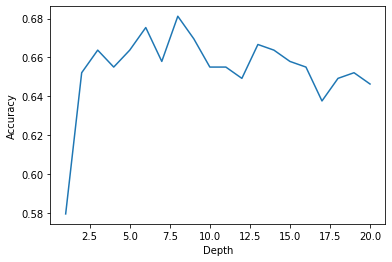

the best max depth value is  8
and the corresponding accuracy rate is  0.6811594202898551


In [ ]:
# decision tree
DT_acc = np.zeros(20)
for d in range(1,21):
  tree = DecisionTree(max_depth=d,cost_fn=cost_gini_index)
  probs_test = tree.fit(x_train, y_train).predict(x_test)
  y_pred_DT = np.argmax(probs_test, 1)
  DT_acc[d-1] = evaluate_acc(y_pred_DT, y_test)
plt.plot(np.arange(1,21), DT_acc)
plt.xlabel("Depth")
plt.ylabel("Accuracy")
# plt.title("my brain activity")
plt.show()

bestD = np.argmax(DT_acc)+1

print("the best max depth value is ", bestD)
print("and the corresponding accuracy rate is ",DT_acc[bestD-1])

##### **Running Actual KNN Model for test**

In [ ]:
# K nearest neighbours
model = KNN(K=bestK,dist_fn=cosine)
y_prob, knns = model.fit(x_train, y_train).predict(x_test)
y_pred_KNN = np.argmax(y_prob, axis=-1)
test_accuracy = evaluate_acc(y_pred_KNN, y_test)
print("the KNN test set accuracy for the hepatitis dataset is ",test_accuracy)

the KNN test set accuracy for the hepatitis dataset is  0.7043478260869566


##### **Decision Boundary for KNN**

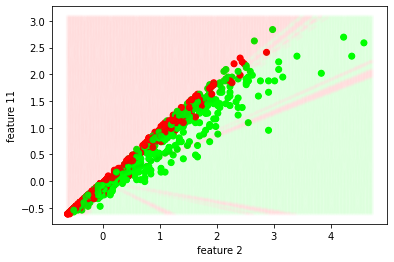

In [ ]:
# compute correlation between features
df_corr = df.corr()

# the two features that most highly correlate with class are features 2 and 11, correspond to index 3 and 6 in array
x_plot = np.stack((x[:,3], x[:,6]), axis=1)
x_train_plot = np.stack((x_train[:,3], x_train[:,6]), axis=1)

x0v = np.linspace(np.min(x_plot[:,0]), np.max(x_plot[:,0]), 200)
x1v = np.linspace(np.min(x_plot[:,1]), np.max(x_plot[:,1]), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = KNN(K=bestK,dist_fn=cosine)

y_train_prob = np.zeros((y_train.shape[0], 3))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

#to get class probability of all the points in the 2D grid
y_prob_all, _ = model.fit(x_train_plot, y_train).predict(x_all)

y_pred_all = np.zeros((y_prob_all.shape[0],3))
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

plt.scatter(x_train_plot[:,0], x_train_plot[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
plt.xlabel('feature 2')
plt.ylabel('feature 11')
plt.show()

##### **Running Actual Decision tree Model for test**

In [ ]:
# decision tree
bestDepth = bestD #change after hyperparamter is tuned!
tree = DecisionTree(max_depth=bestDepth,cost_fn=cost_gini_index)
probs_test = tree.fit(x_train, y_train).predict(x_test)
y_pred_DT = np.argmax(probs_test, 1)
test_accuracy = evaluate_acc(y_pred_DT, y_test)
print("the Decision Tree test set accuracy for the diabetes dataset is ",test_accuracy)

the Decision Tree test set accuracy for the diabetes dataset is  0.5855072463768116


##### **Decision Boundary for Decision Tree**

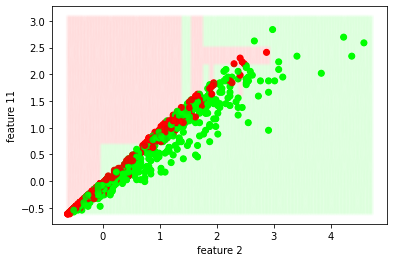

In [ ]:
x_plot = np.stack((x[:,3], x[:,6]), axis=1)
x_train_plot = np.stack((x_train[:,3], x_train[:,6]), axis=1)

x0v = np.linspace(np.min(x_plot[:,0]), np.max(x_plot[:,0]), 200)
x1v = np.linspace(np.min(x_plot[:,1]), np.max(x_plot[:,1]), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = DecisionTree(max_depth=bestDepth,cost_fn=cost_gini_index)

y_train_prob = np.zeros((y_train.shape[0], 3))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

#to get class probability of all the points in the 2D grid
y_prob_all = model.fit(x_train_plot, y_train).predict(x_all)

y_pred_all = np.zeros((y_prob_all.shape[0],3))
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

plt.scatter(x_train_plot[:,0], x_train_plot[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
plt.xlabel('feature 2')
plt.ylabel('feature 11')
plt.show()